# Урок 9. Python применение продвинутых методов 

## Задание:
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.
Mobile Games AB Testing with Cookie Cats


## Решение ##

In [62]:
#Загрузка библиотек

import numpy as np
import pandas as pd

import scipy.stats as stats
from statsmodels.stats import proportion

import statsmodels.stats.power as smp

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

ОБ ИГРЕ:  
Cookie Cats — чрезвычайно популярная мобильная игра-головоломка, разработанная Tactile Entertainment. Это классическая игра-головоломка в стиле «соедини три», в которой игрок должен соединять плитки одного цвета (собирать печенье и кормить голодных кошек), чтобы очистить игровое поле и выиграть уровень.  

![Sem9jpg1.jpg](Sem9jpg1.jpg)  

По мере прохождения уровней игры игроки будут время от времени сталкиваться с воротами, которые заставят их ждать определенное количество времени или совершать покупки в приложении для прохождения.  
_Ворота — это паузы в игре, когда пользователь должен совершить покупку в приложении или подождать определенное время,
прежде чем перейти на следующий уровень._  
Помимо стимулирования покупок в приложении, эти ворота служат важной цели, давая игрокам принудительный перерыв в игре, что должно привести к увеличению и продлению удовольствия игрока от игры.

![Sem9jpg2.jpg](Sem9jpg2.jpg)  

В этом анализе мы ответим на вопрос:  
Следует ли перенести ворота с уровня 30 на уровень 40.  
Для этого я использую результаты  A/B-тестирования, чтобы решить, на каком уровне разместить ворота в игре.

### Подготовка данных
- загрузка
- проверка 
- обработка и очистка

In [63]:
df = pd.read_csv('Sem9Test.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


**_Описание:_**

**userid** - уникальный номер, который идентифицирует каждого игрока.

**version** - был ли игрок поставлен в контрольную группу (gate_30 - ворота 30 уровня) или в группу с перемещенными воротами (gate_40 - ворота 40 уровня).

**sum_gamerounds** - количество раундов, сыгранных каждым игроком в течение первых 14 дней после установки.

**retention_1** - вернулся ли игрок в игру через 1 день после установки.

**retention_7** - вернулся ли игрок в игру через 7 дней после установки.

In [65]:
df.groupby('version')['version'].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

Количество игроков в обеих тестируемых группах сопоставимо

In [66]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [67]:
df.groupby('userid', as_index=False).agg({'version': pd.Series.nunique}).query('version > 1')

,userid,version


In [68]:
df.duplicated().sum()

0

In [69]:
df["userid"].nunique()

90189

In [70]:
df[['sum_gamerounds', 'retention_1', 'retention_7']].describe()

,sum_gamerounds,retention_1,retention_7
count,90189.000000,90189.000000,90189.000000
mean,51.872457,0.445210,0.186065
std,195.050858,0.496992,0.389161
min,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000
50%,16.000000,0.000000,0.000000
75%,51.000000,1.000000,0.000000
max,49854.000000,1.000000,1.000000


Уберем аномальный выброс в поле sum_gamerounds.

In [71]:
df = df[df['sum_gamerounds'] < 49000]

In [72]:
df['version'].value_counts()

gate_40    45489
gate_30    44699
Name: version, dtype: int64

In [73]:
df['retention_1'].value_counts()

0    50035
1    40153
Name: retention_1, dtype: int64

In [74]:
df['retention_7'].value_counts()

0    73408
1    16780
Name: retention_7, dtype: int64

In [75]:
df.groupby('version').agg({'userid': 'count', 'retention_1': 'mean', 'retention_7': 'mean', 'sum_gamerounds': sum})

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44699,0.448198,0.190183,2294941
gate_40,45489,0.442283,0.182000,2333530


**Анализ исходных данных показал**:
1. Пустых данных в выборке нет.
2. Количество пользователей в группах gate_30/gate_40 примерно одинаковое, дублей в userid нет - система сплитования трафика отработала хорошо.
3. Отрицательных (ошибочных) значений в выборке нет.
4. Поле version имеет два значения gate_30/gate_40 - ошибочных значений нет.
5. Поля retention_1 и retention_7 содержит два значения: 0/1 - ошибочных значений нет.



### Метрика: количество раундов, сыгранных каждым игроком в течение первых 14 дней после установки (**_sum_gamerounds_**).



<u>Проверим данные на нормальность.</u>

In [76]:
A = df.query('version == "gate_30"')
B = df.query('version == "gate_40"')
n1, n2 = A.shape[0], B.shape[0]

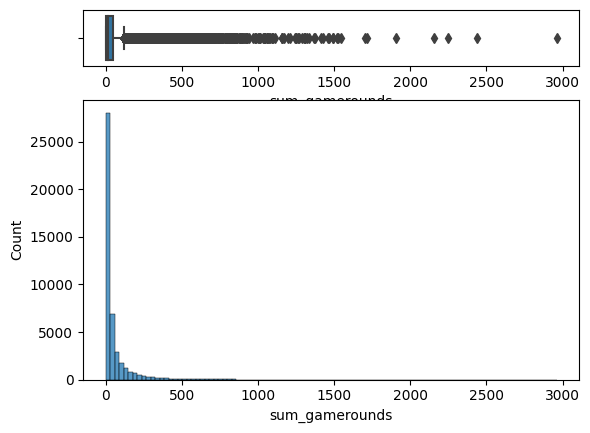

In [77]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.5, 2.5]})
sns.boxplot(x=A['sum_gamerounds'], ax=ax[0]);
sns.histplot(A['sum_gamerounds'], bins=100, ax=ax[1]);

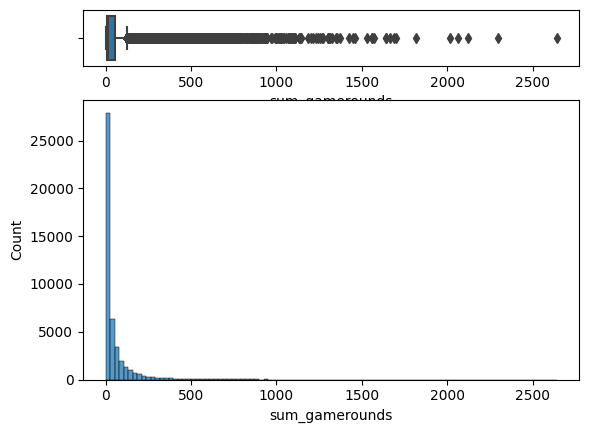

In [78]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.5, 2.5]})
sns.boxplot(x=B['sum_gamerounds'], ax=ax[0]);
sns.histplot(B['sum_gamerounds'], bins=100, ax=ax[1]);

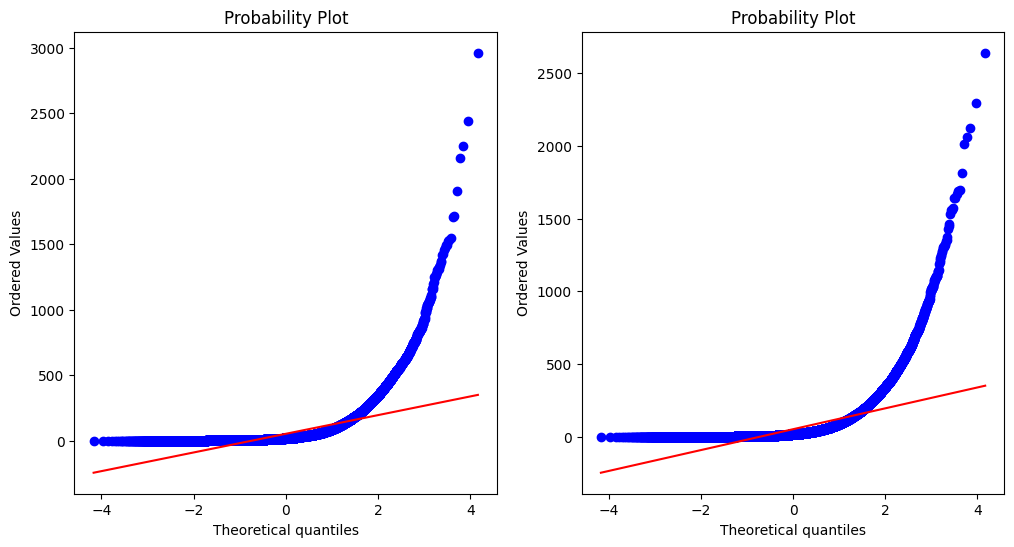

In [79]:
plt.figure(figsize = [6*2, 6])

plt.subplot(1, 2, 1)
norm = stats.probplot(A['sum_gamerounds'], dist="norm", plot=plt)

plt.subplot(1, 2, 2)
norm = stats.probplot(B['sum_gamerounds'], dist="norm", plot=plt)

In [80]:
stats.kstest(A['sum_gamerounds'], 'norm')

KstestResult(statistic=0.8724153079945488, pvalue=0.0, statistic_location=2, statistic_sign=-1)

p-value < 0.05, следовательно предположение о нормальном распределении в контрольной группе (gate_30) **не** верно.

In [81]:
stats.kstest(B['sum_gamerounds'], 'norm')

KstestResult(statistic=0.8707186187388001, pvalue=0.0, statistic_location=2, statistic_sign=-1)

p-value < 0.05, следовательно предположение о нормальном распределении в тестовой группе (gate_40) **не** верно.

Данные распределены ненормально, поэтому для оценки равенства средних начений двух выборок используем критерий Манна-Уитни.

In [82]:
stats.mannwhitneyu(x=A['sum_gamerounds'].values,
                   y=B['sum_gamerounds'].values)

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

_Вывод._  
Так как p-value > 0.05 то мы принимаем нулевую гипотезу о равенстве средних значений количества раундов в двух выборках, т.е. между gate_30 и gate_40 статистически значимых различий в прохождении игры нет.

<u>Проверим, достаточна ли была мощность наших выборок, чтобы анализировать результаты.</u>

In [83]:
Ma, Mb = A['sum_gamerounds'].mean(), B['sum_gamerounds'].mean()
Da, Db = A['sum_gamerounds'].var(), B['sum_gamerounds'].var()

effect_size = (Ma-Mb)/np.sqrt(((n1-1)*Da + (n2-1)*Db)/(n1+n2-2))
effect_size

0.0004220261663114191

In [84]:
analysis = smp.TTestIndPower()
analysis.solve_power(effect_size=effect_size, alpha=0.05, power=None, nobs1=n1, ratio=n2/n1)

0.05046009024737237

_Вывод._
Мощность теста для набора данных (5%) очень низкая. С такой мощностью мы не можем быть уверены в результатах теста. Мы могли не получить статистически значимую разницу, т.к. у нас недостаточный объем выборки. Эксперименты могли быть поставлены или проведены некорректно, или мала длительность.

**Рекомендация: рассчитать требуемый размер выборки и избегать преждевременной остановки теста**.

In [85]:
analysis.solve_power(effect_size=0.01, alpha=0.05, power=0.8, nobs1=None, ratio=1)

156978.172860403

_Вывод._  
Для достоверного обнаружения эффекта в 1% нужно провести не менее $157000$ испытаний в каждой группе, итого $157000 \cdot 2 = 314000$. 

### Метрика: возвращение игрока в игру через 1 день после установки (**retention_1**)

Проведем Z-тест пропорций на уровне значимости $\alpha=0.05$

$H_0: p_1 = p_2 \\
H_1: p1 \not= p_2$

$p_1 = \cfrac{m_1}{n_1}, p_2 = \cfrac{m_2}{n_2}$

In [86]:
m1 = A['retention_1'].sum()
m2 = B['retention_1'].sum()

proportion.proportions_ztest(np.array([m1, m2]), np.array([n1, n2]), alternative='two-sided')

(1.787103509763628, 0.0739207603418346)

_Вывод._  
Так как p-value > 0.05 то мы **принимаем** нулевую гипотезу о равенстве доли вернувшихся в игру через 1 день в двух выборках. \
В группах gate_30 и gate_40 **не** обнаружены статистически значимые отличия по метрике **retention_1**.

### Метрика: возвращение игрока в игру через 7 день после установки (**retention_7**)

Проведем Z-тест пропорций на уровне значимости $\alpha=0.05$

$H_0: p_1 = p_2 \\
H_1: p1 \not= p_2$

$p_1 = \cfrac{m_1}{n_1}, p_2 = \cfrac{m_2}{n_2}$

In [87]:
m1 = A.query('retention_7 == 1')['retention_7'].sum()
m2 = B.query('retention_7 == 1')['retention_7'].sum()

proportion.proportions_ztest(np.array([m1, m2]), np.array([n1, n2]))

(3.1574100858819936, 0.0015917731773993442)

_Вывод._  
Так как p-value < 0.05 то мы **отвергаем** нулевую гипотезу о равенстве доли вернувшихся в игру через 7 день в двух выборках. \
В группах gate_30 и gate_40 обнаружены статистически значимые отличия по **retention_7**.

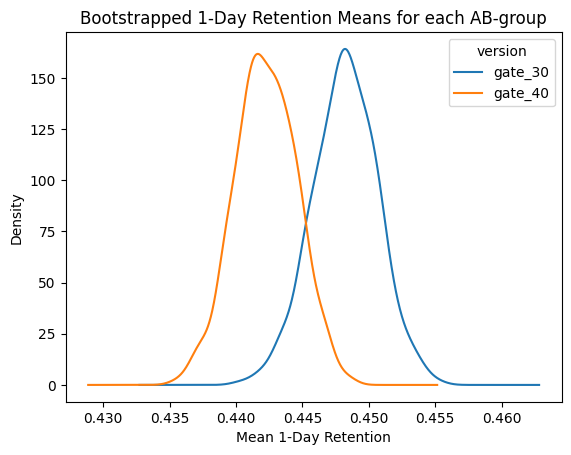

In [88]:
boot_1d = []
iterations=500
for i in range(iterations):
    boot_mean = df.sample(frac=1, replace=True).groupby(
        'version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d)
    
ax = boot_1d.plot.kde()
ax.set_title('Bootstrapped 1-Day Retention Means for each AB-group')
ax.set_xlabel('Mean 1-Day Retention');

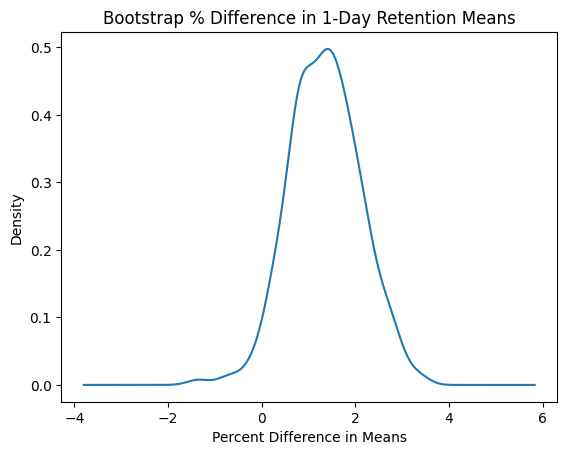

In [89]:
boot_1d['diff'] = ((boot_1d.gate_30 - boot_1d.gate_40)
                   / boot_1d.gate_40 * 100)

ax = boot_1d['diff'].plot.kde()
ax.set_xlabel('Percent Difference in Means')
ax.set_title('Bootstrap % Difference in 1-Day Retention Means');

'100.0%'

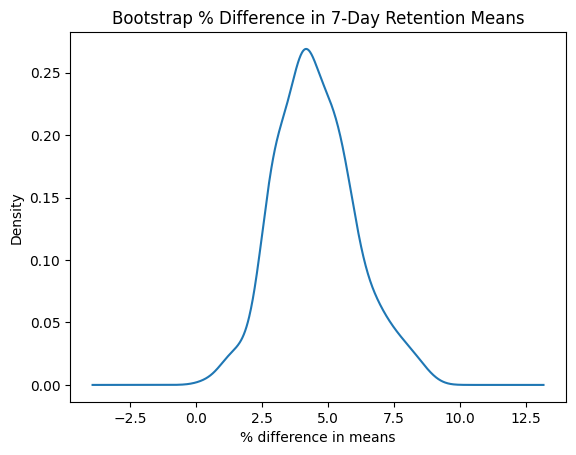

In [90]:
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby(
        'version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d)

boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / 
                   boot_7d['gate_40'] * 100)

ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("% difference in means")
ax.set_title('Bootstrap % Difference in 7-Day Retention Means');

prob = (boot_7d['diff'] > 0).mean()

'{0:.1%}'.format(prob)

_Вывод._  
Результат bootstrap говорит нам о том, что существуют убедительные доказательства того, что 7-дневное "удержание"(Retention) выше, когда "ворота" находятся на уровне 30, чем когда они находятся на уровне 40.  
Если мы хотим сохранить высокое "удержание" — и 1-дневное, и 7-дневное  "удержание" — мы не должны перемещать "ворота" с уровня 30 на уровень 40.

Иными словами, когда "ворота" перемещаются на уровень 40, меньше игроков дойдут до них и они с большей вероятностью покинут игру навсегда.

**В итоге рекомендуется:**
1. Не вводить изменения по перемещению ворот на уровень 40.
2. Увеличить размер выборки до 314000 пользователей. Это позволит поднять мощность тестов по выбранным метрикам и получать более объективную оценку вводимых в игру изменений.
3. Уточнить дизайн А/В теста и запустить его заново.